# Data Augmentation in batch form and running on GPU/TPU.

This notebook implements a batch form of Chris Deotte's great data augmention in [Rotation Augmentation GPU/TPU - [0.96+]](https://www.kaggle.com/cdeotte/rotation-augmentation-gpu-tpu-0-96).

It also shows how to perform data augmentation on GPU / TPU directly.
    
    * [Important] Although running data augmentation directly on GPU/TPU is faster, it loses the advantage of separating the data processing on CPU and model training on GPU/TPU.
    * Therefore, we don't encourage the idea of using tf.keras.layers.Layer for data augmentation shown in this kernel.
    * However, the batch implementation is still beneficial when doing data augmentation on CPU by using tf.data.Dataset.
    * In order to make the measurement of timing, we measure it with a dummy layer which does the data processing in GPU / TPU, but return dummy tensor. This is to avoid the overhead of sending large tensor back to CPU.


In [ ]:
import math, re, os
import tensorflow as tf
import tensorflow.keras.backend as K
import numpy as np
from matplotlib import pyplot as plt
from kaggle_datasets import KaggleDatasets
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
import datetime
import tqdm
print("Tensorflow version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE

# Configurations

In [ ]:
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

print("REPLICAS: ", strategy.num_replicas_in_sync)

In [ ]:
AUTO = tf.data.experimental.AUTOTUNE

# Configuration
IMAGE_SIZE = [512, 512]
BATCH_SIZE = 16 * strategy.num_replicas_in_sync

# Data Directories

In [ ]:
# Data access
GCS_DS_PATH = KaggleDatasets().get_gcs_path('tpu-getting-started')

GCS_PATH_SELECT = { # available image sizes
    192: GCS_DS_PATH + '/tfrecords-jpeg-192x192',
    224: GCS_DS_PATH + '/tfrecords-jpeg-224x224',
    331: GCS_DS_PATH + '/tfrecords-jpeg-331x331',
    512: GCS_DS_PATH + '/tfrecords-jpeg-512x512'
}

GCS_PATH = GCS_PATH_SELECT[IMAGE_SIZE[0]]

TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train/*.tfrec')
VALIDATION_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/val/*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test/*.tfrec') # predictions on this dataset should be submitted for the competition

# Classes

In [ ]:
CLASSES = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose']                                                                                                                                               # 100 - 102

# Dataset Functions
From starter [kernel][1]

[1]: https://www.kaggle.com/mgornergoogle/getting-started-with-100-flowers-on-tpu

In [ ]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label # returns a dataset of (image, label) pairs

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "id": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
        # class is missing, this competitions's challenge is to predict flower classes for the test dataset
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['id']
    return image, idnum # returns a dataset of image(s)

def load_dataset(filenames, labeled = True, ordered = False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # Diregarding data order. Order does not matter since we will be shuffling the data anyway
    
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed
        
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads = AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # use data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls = AUTO) # returns a dataset of (image, label) pairs if labeled = True or (image, id) pair if labeld = False
    return dataset

def data_augment(image, label):
    # data augmentation. Thanks to the dataset.prefetch(AUTO) statement in the next function (below),
    # this happens essentially for free on TPU. Data pipeline code is executed on the "CPU" part
    # of the TPU while the TPU itself is computing gradients.
    image = tf.image.random_flip_left_right(image)
    return image, label   

def get_validation_dataset(dataset):
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_test_dataset(ordered=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

NUM_TRAINING_IMAGES = int(count_data_items(TRAINING_FILENAMES))
NUM_VALIDATION_IMAGES = int(count_data_items(VALIDATION_FILENAMES))
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE

print('Dataset: {} training images, {} validation images, {} unlabeled test images'.format(NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES))

# Data Augmentation
The following code does random rotations, shear, zoom, and shift using the GPU/TPU. When an image gets moved away from an edge revealing blank space, the blank space is filled by stretching the colors on the original edge. Change the variables in function `transform()` below to control the desired amount of augmentation. Here's a diagram illustrating the mathematics.

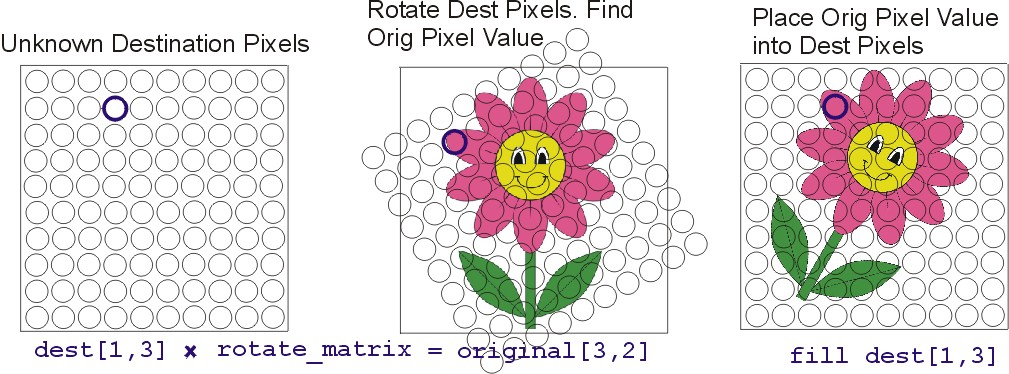

In [ ]:
def get_mat(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    # returns 3x3 transformmatrix which transforms indicies
        
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    shear = math.pi * shear / 180.
    
    # ROTATION MATRIX
    c1 = tf.math.cos(rotation)
    s1 = tf.math.sin(rotation)
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    rotation_matrix = tf.reshape( tf.concat([c1,s1,zero, -s1,c1,zero, zero,zero,one],axis=0),[3,3] )
        
    # SHEAR MATRIX
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)
    shear_matrix = tf.reshape( tf.concat([one,s2,zero, zero,c2,zero, zero,zero,one],axis=0),[3,3] )    
    
    # ZOOM MATRIX
    zoom_matrix = tf.reshape( tf.concat([one/height_zoom,zero,zero, zero,one/width_zoom,zero, zero,zero,one],axis=0),[3,3] )
    
    # SHIFT MATRIX
    shift_matrix = tf.reshape( tf.concat([one,zero,height_shift, zero,one,width_shift, zero,zero,one],axis=0),[3,3] )
    
    return K.dot(K.dot(rotation_matrix, shear_matrix), K.dot(zoom_matrix, shift_matrix))

In [ ]:
def transform(image, label):
    
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated, sheared, zoomed, and shifted
    DIM = IMAGE_SIZE[0]
    XDIM = DIM%2 #fix for size 331
    
    rot = 15. * tf.random.normal([1],dtype='float32')
    shr = 5. * tf.random.normal([1],dtype='float32') 
    h_zoom = 1.0 + tf.random.normal([1],dtype='float32')/10.
    w_zoom = 1.0 + tf.random.normal([1],dtype='float32')/10.
    h_shift = 16. * tf.random.normal([1],dtype='float32') 
    w_shift = 16. * tf.random.normal([1],dtype='float32') 
  
    # GET TRANSFORMATION MATRIX
    m = get_mat(rot,shr,h_zoom,w_zoom,h_shift,w_shift) 

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(m,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES           
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image,tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3]), label

# Measure timing

In [ ]:
def get_training_dataset(dataset, batch_size=None, do_aug=True, advanced_aug=True, repeat=True, with_labels=True, drop_remainder=False):
    
    if do_aug:
        dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
        
    if not with_labels:
        dataset = dataset.map(lambda image, label: image, num_parallel_calls=AUTO)
    
    if advanced_aug:
        dataset = dataset.map(transform, num_parallel_calls=AUTO)
    
    if type(repeat) == bool and repeat:
        dataset = dataset.repeat() # the training dataset must repeat for several epochs
    elif type(repeat) == int and repeat > 0:
        dataset = dataset.repeat(repeat)
    
    dataset = dataset.shuffle(2048)
    
    if batch_size is None:
        batch_size = BATCH_SIZE
    
    dataset = dataset.batch(batch_size, drop_remainder=drop_remainder)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    
    return dataset

# Timing without any data augmentation

In [ ]:
n_iter = 3
dataset = load_dataset(TRAINING_FILENAMES, labeled=True)

In [ ]:
training_dataset = get_training_dataset(dataset, do_aug=False, advanced_aug=False, repeat=1, with_labels=True)

start = datetime.datetime.now()

for i in tqdm.tqdm(range(n_iter)):
    # Iterate over the whole training dataset
    for image, labe in training_dataset:
        pass

end = datetime.datetime.now()
elapsed = (end - start).total_seconds()
average = elapsed / n_iter
print("Average timing for 1 iteration = {}".format(average))

# Timing with advanced (Chris Deotte's) data augumentation only

In [ ]:
training_dataset = get_training_dataset(dataset, do_aug=False, advanced_aug=True, repeat=1, with_labels=True)

start = datetime.datetime.now()

for i in tqdm.tqdm(range(n_iter)):
    # Iterate over the whole training dataset
    for image, labe in training_dataset:
        pass

end = datetime.datetime.now()
elapsed = (end - start).total_seconds()
average = elapsed / n_iter
print("Average timing for 1 iteration = {}".format(average))

# Using GPU / TPU

In [ ]:
def get_batch_transformatioin_matrix(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    """Returns a tf.Tensor of shape (batch_size, 3, 3) with each element along the 1st axis being
       an image transformation matrix (which transforms indicies).

    Args:
        rotation: 1-D Tensor with shape [batch_size].
        shear: 1-D Tensor with shape [batch_size].
        height_zoom: 1-D Tensor with shape [batch_size].
        width_zoom: 1-D Tensor with shape [batch_size].
        height_shift: 1-D Tensor with shape [batch_size].
        width_shift: 1-D Tensor with shape [batch_size].
        
    Returns:
        A 3-D Tensor with shape [batch_size, 3, 3].
    """    

    # A trick to get batch_size
    batch_size = tf.cast(tf.reduce_sum(tf.ones_like(rotation)), tf.int64)    
    
    # CONVERT DEGREES TO RADIANS
    rotation = tf.constant(math.pi) * rotation / 180.0
    shear = tf.constant(math.pi) * shear / 180.0

    # shape = (batch_size,)
    one = tf.ones_like(rotation, dtype=tf.float32)
    zero = tf.zeros_like(rotation, dtype=tf.float32)
    
    # ROTATION MATRIX
    c1 = tf.math.cos(rotation) # shape = (batch_size,)
    s1 = tf.math.sin(rotation) # shape = (batch_size,)

    # Intermediate matrix for rotation, shape = (9, batch_size) 
    rotation_matrix_temp = tf.stack([c1, s1, zero, -s1, c1, zero, zero, zero, one], axis=0)
    # shape = (batch_size, 9)
    rotation_matrix_temp = tf.transpose(rotation_matrix_temp)
    # Fianl rotation matrix, shape = (batch_size, 3, 3)
    rotation_matrix = tf.reshape(rotation_matrix_temp, shape=(batch_size, 3, 3))
        
    # SHEAR MATRIX
    c2 = tf.math.cos(shear) # shape = (batch_size,)
    s2 = tf.math.sin(shear) # shape = (batch_size,)
    
    # Intermediate matrix for shear, shape = (9, batch_size) 
    shear_matrix_temp = tf.stack([one, s2, zero, zero, c2, zero, zero, zero, one], axis=0)
    # shape = (batch_size, 9)
    shear_matrix_temp = tf.transpose(shear_matrix_temp)
    # Fianl shear matrix, shape = (batch_size, 3, 3)
    shear_matrix = tf.reshape(shear_matrix_temp, shape=(batch_size, 3, 3))    
    

    # ZOOM MATRIX
    
    # Intermediate matrix for zoom, shape = (9, batch_size) 
    zoom_matrix_temp = tf.stack([one / height_zoom, zero, zero, zero, one / width_zoom, zero, zero, zero, one], axis=0)
    # shape = (batch_size, 9)
    zoom_matrix_temp = tf.transpose(zoom_matrix_temp)
    # Fianl zoom matrix, shape = (batch_size, 3, 3)
    zoom_matrix = tf.reshape(zoom_matrix_temp, shape=(batch_size, 3, 3))
    
    # SHIFT MATRIX
    
    # Intermediate matrix for shift, shape = (9, batch_size) 
    shift_matrix_temp = tf.stack([one, zero, height_shift, zero, one, width_shift, zero, zero, one], axis=0)
    # shape = (batch_size, 9)
    shift_matrix_temp = tf.transpose(shift_matrix_temp)
    # Fianl shift matrix, shape = (batch_size, 3, 3)
    shift_matrix = tf.reshape(shift_matrix_temp, shape=(batch_size, 3, 3))    
        
    return tf.linalg.matmul(tf.linalg.matmul(rotation_matrix, shear_matrix), tf.linalg.matmul(zoom_matrix, shift_matrix))


def batch_transform(images):
    """Returns a tf.Tensor of the same shape as `images`, represented a batch of randomly transformed images.

    Args:
        images: 4-D Tensor with shape (batch_size, width, hight, depth).
            Currently, `depth` can only be 3.
        
    Returns:
        A 4-D Tensor with the same shape as `images`.
    """ 
    
    # input `images`: a batch of images [batch_size, dim, dim, 3]
    # output: images randomly rotated, sheared, zoomed, and shifted
    DIM = images.shape[1]
    XDIM = DIM % 2  # fix for size 331
    
    # A trick to get batch_size
    batch_size = tf.cast(tf.reduce_sum(tf.ones_like(images)) / (images.shape[1] * images.shape[2] * images.shape[3]), tf.int64)
    
    rot = 15.0 * tf.random.normal([batch_size], dtype='float32')
    shr = 5.0 * tf.random.normal([batch_size], dtype='float32') 
    h_zoom = 1.0 + tf.random.normal([batch_size], dtype='float32') / 10.0
    w_zoom = 1.0 + tf.random.normal([batch_size], dtype='float32') / 10.0
    h_shift = 16.0 * tf.random.normal([batch_size], dtype='float32') 
    w_shift = 16.0 * tf.random.normal([batch_size], dtype='float32') 
  
    # GET TRANSFORMATION MATRIX
    # shape = (batch_size, 3, 3)
    m = get_batch_transformatioin_matrix(rot, shr, h_zoom, w_zoom, h_shift, w_shift) 

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat(tf.range(DIM // 2, -DIM // 2, -1), DIM)  # shape = (DIM * DIM,)
    y = tf.tile(tf.range(-DIM // 2, DIM // 2), [DIM])  # shape = (DIM * DIM,)
    z = tf.ones([DIM * DIM], dtype='int32')  # shape = (DIM * DIM,)
    idx = tf.stack([x, y, z])  # shape = (3, DIM * DIM)
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = tf.linalg.matmul(m, tf.cast(idx, dtype='float32'))  # shape = (batch_size, 3, DIM ** 2)
    idx2 = K.cast(idx2, dtype='int32')  # shape = (batch_size, 3, DIM ** 2)
    idx2 = K.clip(idx2, -DIM // 2 + XDIM + 1, DIM // 2)  # shape = (batch_size, 3, DIM ** 2)
    
    # FIND ORIGIN PIXEL VALUES
    # shape = (batch_size, 2, DIM ** 2)
    idx3 = tf.stack([DIM // 2 - idx2[:, 0, ], DIM // 2 - 1 + idx2[:, 1, ]], axis=1)  
    
    # shape = (batch_size, DIM ** 2, 3)
    d = tf.gather_nd(images, tf.transpose(idx3, perm=[0, 2, 1]), batch_dims=1)
        
    # shape = (batch_size, DIM, DIM, 3)
    new_images = tf.reshape(d, (batch_size, DIM, DIM, 3))

    return new_images

class Data_Augmentation_Dummy(tf.keras.layers.Layer):
    """
    This dummy class is used for measuring timing without the overhead of sending large tensors back to CPU from GPU / TPU.
    Otherwise, it won't be faster then data processing on CPU by tf.data.Dataset API directly (sometimes, even slower).
    """
    
    def __init__(self):
        
        super(Data_Augmentation_Dummy, self).__init__()
        

    def build(self, input_shape):  # Create the state of the layer (weights)
    
        pass
        
    def call(self, inputs):  # Defines the computation from inputs to outputs
        
        images = inputs
        batch_size = tf.cast(tf.reduce_sum(tf.ones_like(images)) / (images.shape[1] * images.shape[2] * images.shape[3]), tf.int64)    
        
        new_images = batch_transform(images)
        
        # We return dummy value here in order to avoid the overhead of sending tensor back to CPU from GPU.
        # We will make a real one later.
        return tf.zeros(shape=(batch_size,))

# An example usage

In [ ]:
input_layer = tf.keras.layers.InputLayer(
    input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3), name='input_layer'
)

data_augmentation_layer = Data_Augmentation_Dummy()

with strategy.scope():
    
    model = tf.keras.Sequential([
        input_layer,
        data_augmentation_layer
    ])

# Timing with advanced data augumentation run in GPU / TPU

In [ ]:
training_dataset = get_training_dataset(dataset, do_aug=False, advanced_aug=False, repeat=1, with_labels=False, drop_remainder=True)

start = datetime.datetime.now()

    
for i in tqdm.tqdm(range(n_iter)):
    model.predict(training_dataset)
    
end = datetime.datetime.now()
elapsed = (end - start).total_seconds()
average = elapsed / n_iter
print("Average timing for 1 iteration = {}".format(average))

# Check data augmentation effect

In [ ]:
def batch_to_numpy_images_and_labels(data):
    
    images = data
    numpy_images = images.numpy()

    # If no labels, only image IDs, return None for labels (this is the case for test data)
    return numpy_images


def display_one_flower(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)


def display_batch_of_images(databatch, predictions=None):
    
    """This will work with:
    display_batch_of_images(images)
    """
    
    # data
    images = batch_to_numpy_images_and_labels(databatch)
    labels = None
    
    if labels is None:
        labels = [None for _ in enumerate(images)]
        
    # auto-squaring: this will drop data that does not fit into square or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
        
    # size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else CLASSES[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one_flower(image, title, subplot, not correct, titlesize=dynamic_titlesize)
    
    #layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()

# Use actual Data_Augmentation layer

In [ ]:
training_dataset = get_training_dataset(dataset, batch_size=16, do_aug=False, advanced_aug=False, repeat=1, with_labels=False)

class Data_Augmentation(tf.keras.layers.Layer):
    """
    This layer is ready to be used along with image class models.
    """
    
    def __init__(self):
        
        super(Data_Augmentation, self).__init__()
        

    def build(self, input_shape):  # Create the state of the layer (weights)
    
        pass
        
    def call(self, inputs):  # Defines the computation from inputs to outputs
    
        new_images = batch_transform(inputs)
        
        return new_images
    
input_layer = tf.keras.layers.InputLayer(
    input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3), name='input_layer'
)

data_augmentation_layer = Data_Augmentation()

with strategy.scope():
    
    model = tf.keras.Sequential([
        input_layer,
        data_augmentation_layer
    ])
    

images = next(iter(training_dataset.take(1)))
print(images.shape)
new_images = model(images)
print(new_images.shape)

# Original images

In [ ]:
display_batch_of_images(images)

# Transformed images

In [ ]:
display_batch_of_images(new_images)